In [160]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [161]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['font.family']='Arial'

In [162]:
save_folder = r'D:\DNA_FISH\Sox2_Knockout_Project'

In [163]:
from pathlib import Path
paths = []

for path in Path('D:\DNA_FISH').rglob('*129_log_contact.npy'):
    paths.append(path)

In [164]:
class Experiment:
    
    def __init__(self, base_dir):
        
        import glob, os
        
        self.base_dir = str(base_dir)
        self.single_cell_data = str(base_dir)+os.sep+r'/scratch/single_cell_data.csv'
        self.matrices = np.array(glob.glob(str(base_dir)+os.sep+r'*.npy'))
        self.median_129 = str(base_dir)+os.sep+r'129_median_matrix.npy'
        self.median_cast = str(base_dir)+os.sep+r'CAST_median_matrix.npy'
        self.contact_cast = str(base_dir)+os.sep+r'CAST_log_contact.npy'
        self.contact_129 = str(base_dir)+os.sep+r'129_log_contact.npy'
        self.stdev_cast = str(base_dir)+os.sep+r'CAST_stdev_matrix.npy'
        self.stdev_129 = str(base_dir)+os.sep+r'129_stdev_matrix.npy'
        self.combine_median = str(base_dir)+os.sep+r'median_distance_matrix.npy'
        self.combine_contact = str(base_dir)+os.sep+r'AJ_combine_matrix_contact.npy'
        self.diff_medians = str(base_dir)+os.sep+r'diff_of_medians.npy'
        self.log_diff_contact = str(base_dir)+os.sep+r'log_diff_of_contact.npy'
        self.deviation_129 = str(base_dir)+os.sep+r'stdev_129_diff_gauss_chain.npy'
        self.deviation_cast = str(base_dir)+os.sep+r'stdev_cast_diff_gauss_chain.npy'
        self.diff_deviations = str(base_dir)+os.sep+r'diff_of_deviations.npy'
        self.traces_cast = str(base_dir)+os.sep+r'/scratch/cast_allele_coords.npy'
        self.traces_129 = str(base_dir)+os.sep+r'/scratch/129_allele_coords.npy'
        self.ep_dists_cast = str(base_dir)+os.sep+r'/scratch/cast_e_p_dists.npy'
        self.ep_dists_129 = str(base_dir)+os.sep+r'/scratch/noncast_e_p_dists.npy'
        self.boundary_prob_cast = str(base_dir)+os.sep+r'/scratch/boundary_prob_cast.npy'
        self.boundary_prob_129 = str(base_dir)+os.sep+r'/scratch/boundary_prob_129.npy'
        self.cids = str(base_dir)+os.sep+r'/scratch/cids_final.npy'
        f = open(str(base_dir)+os.sep+r'experiment_params.txt')
        for idx,line in enumerate(f):
            if idx == 0:
                self.experiment_name = str(line).split(' = ')[-1][:-1]
            elif idx == 1:
                self.em_th = float(line.split(' = ')[-1][:-1])
                
    def __str__(self):
        
        return self.experiment_name
                
        

In [165]:
from pathlib import Path
import pandas as pd
import numpy as np

paths = []

for path in Path('D:\DNA_FISH').rglob('*129_log_contact.npy'):
    paths.append(path)

parents = [ i.parent for i in paths ]
expts = []
for e in parents:
    expts.append(Experiment(e))

for idx, expt in enumerate(expts):
    print(idx, ":", expt.experiment_name)


0 : D0023 4CBS Mutant DNA
1 : D0041 4CBS Downstream RNA-DNA
2 : D0052 4CBS DNA
3 : D0068 Kat6b KO
4 : D0071 Kat6b KO Repeat DNA
5 : D0073 Double KO Repeat DNA
6 : D0074 Mau2 KO Repeat DNA
7 : D0075 Nipbl KO Repeat DNA
8 : D0076 Nipbl KO DNA
9 : D0077 Stag2 KO DNA
10 : D0079 Cohesin Degron DNA
11 : D0088 Cohesin Degron +A485
12 : D0089 F10+A485
13 : D0090 Cohesin Degron 12hr+dTag/12hr-dTag
14 : D0091 Rad21-Deg 12hr+dTagA485/12hr-dTag+A485
15 : D0092 CTCF Degron
16 : D0096 F10 Rad21 Degron -dTag
17 : D0097 CTCF Degron -dTag
18 : D0098 C3 CTCF Degron +dTag diff
19 : D0099 C3 CTCF Degron -dTag diff
20 : D0100 H5 Nipbl Degron +dTag
21 : D0101 B2 Wapl Degron +dTag
22 : D0102 CTCF Degron -dTag +a485 Recovery
23 : D0103 CTCF Degron +dTag +a485 Recovery
24 : D0104 CTCF Degron +a485
25 : D0105 CTCF Degron +dTag +a485
26 : D0106 CTCF Degron +dTag 12hr


In [166]:
def make_plot_geom_distance(expt, zxys_cast_corr, zxys_noncast_corr):
    
    import numpy as np 
        
    def centeroidnp(trace):
        length = trace.shape[0]
        sum_x = np.nansum(trace[:, 1])
        sum_y = np.nansum(trace[:, 2])
        sum_z = np.nansum(trace[:, 0])
        return sum_z/(length-sum(np.isnan(trace[:, 0]))), sum_x/(length-sum(np.isnan(trace[:, 1]))), sum_y/(length-sum(np.isnan(trace[:, 2])))

    def get_dists_from_ctr(array):

        geometric_distances = np.zeros((array.shape[0], array.shape[1]))

        # go through each trace
        for idx, trace in enumerate(array):

            #get trace centeroid
            trace_center = np.array(centeroidnp(trace))

            # compute distance between centeroid and each point (returns a 42 element array for each trace)
            centeroid_distances = np.array([ np.linalg.norm(x) for x in (trace-trace_center) ])

            geometric_distances[idx] = centeroid_distances

        return geometric_distances
    
    cast = get_dists_from_ctr(zxys_cast_corr)
    noncast = get_dists_from_ctr(zxys_noncast_corr)
    noncast[:,25] = np.nan
    
    experiment_name = expt.experiment_name
    analysis_folder = expt.base_dir
    post_analysis_folder = analysis_folder+os.sep+'scratch'
    

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    plt.setp(ax.spines.values(), linewidth=1.5)
    ax.tick_params(width=1.5, length=4, labelsize=14)
    plt.title('Median distance from geometric center for\n'+experiment_name+", "+str(len(cast))+' chromosomes', size=24)
    plt.ylabel('Median Distance from geometric center', size=14)
    plt.xlabel('Genomic Region Number', size=14)
    plt.ylim((100,max(np.nanmedian(noncast, axis=0))+50))
    plt.plot(range(42), np.nanmedian(cast, axis=0), marker='o', color='#1f77b4')
    plt.errorbar(range(42), np.nanmedian(cast, axis=0), yerr=1.96*np.nanstd(cast)/np.sqrt(sum(np.isnan(cast))), color='#1f77b4')
    plt.plot(range(42), np.nanmedian(noncast, axis=0), marker='o', color='#ff7f0e')
    plt.errorbar(range(42), np.nanmedian(noncast, axis=0), yerr=1.96*np.nanstd(noncast)/np.sqrt(sum(np.isnan(noncast))), color='#ff7f0e')
    plt.vlines([9,25, 31], ymin=100, ymax=max(np.nanmedian(noncast, axis=0))+45, colors='r', alpha=0.3, linewidth=10)
    plt.legend(['CAST', '129'])
    fig.savefig(post_analysis_folder+os.sep+'distance_geom_center.pdf',bbox_inches='tight')
    fig.savefig(post_analysis_folder+os.sep+'distance_geom_center.png',bbox_inches='tight')
    # save plot data.
    np.save(analysis_folder+os.sep+r'cast_geom_distance_median.npy', np.nanmedian(cast, axis=0))
    np.save(analysis_folder+os.sep+r'129_geom_distance_median.npy', np.nanmedian(noncast, axis=0))
    np.save(analysis_folder+os.sep+r'cast_geom_distance_errors.npy', 1.96*np.nanstd(cast)/np.sqrt(sum(np.isnan(cast))))
    np.save(analysis_folder+os.sep+r'129_geom_distance_errors.npy', 1.96*np.nanstd(noncast)/np.sqrt(sum(np.isnan(noncast))))
    
    plt.close()
    
    return None

In [167]:
def make_plot_geom_distance_selected(expts, legend, saveloc):
    
    import numpy as np 
        
    def centeroidnp(trace):
        length = trace.shape[0]
        sum_x = np.nansum(trace[:, 1])
        sum_y = np.nansum(trace[:, 2])
        sum_z = np.nansum(trace[:, 0])
        return sum_z/(length-sum(np.isnan(trace[:, 0]))), sum_x/(length-sum(np.isnan(trace[:, 1]))), sum_y/(length-sum(np.isnan(trace[:, 2])))

    def get_dists_from_ctr(array):

        geometric_distances = np.zeros((array.shape[0], array.shape[1]))

        # go through each trace
        for idx, trace in enumerate(array):

            #get trace centeroid
            trace_center = np.array(centeroidnp(trace))

            # compute distance between centeroid and each point (returns a 42 element array for each trace)
            centeroid_distances = np.array([ np.linalg.norm(x) for x in (trace-trace_center) ])

            geometric_distances[idx] = centeroid_distances

        return geometric_distances
    
    # define lists to contain the median distances
    distances_cast_full = [] 
    distances_cast_med = []
    distances_129_full = [] 
    distances_129_med = []
    
    for expt in expts:
    
        zxys_cast_corr = np.load(expt.traces_cast)
        zxys_noncast_corr = np.load(expt.traces_129)
        cast = get_dists_from_ctr(zxys_cast_corr)
        noncast = get_dists_from_ctr(zxys_noncast_corr)
        noncast[:,25] = np.nan
        cast[:,21] = np.nan
        noncast[:,21] = np.nan
        
        distances_cast_full.append((cast))
        distances_cast_med.append(np.nanmedian(cast))
        distances_129_full.append((noncast))
        distances_129_med.append(np.nanmedian(noncast))

    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    plt.setp(ax.spines.values(), linewidth=1.5)
    ax.tick_params(width=1.5, length=4, labelsize=14)
    plt.title('Median distance from geometric center for Selected Experiments - CAST', size=24)
    plt.ylabel('Median Distance from geometric center', size=14)
    plt.xlabel('Genomic Region Number', size=14)
    plt.ylim((100,375))
    for line in distances_cast_full:
        plt.plot(range(42), np.nanmedian(line, axis=0), marker='o')
        #plt.errorbar(range(42), np.nanmedian(line, axis=0), yerr=1.96*np.nanstd(line)/np.sqrt(sum(np.isnan(line))), color='#1f77b4')
    plt.vlines([9,25, 31], ymin=100, ymax=375, colors='r', alpha=0.3, linewidth=10)
    plt.legend(legend)
    
    fig.savefig(saveloc+'_CAST.pdf',bbox_inches='tight')
    fig.savefig(saveloc+'_CAST.png',bbox_inches='tight')
    plt.close()
    
    
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    plt.setp(ax.spines.values(), linewidth=1.5)
    ax.tick_params(width=1.5, length=4, labelsize=14)
    plt.title('Median distance from geometric center for Selected Experiments - 129', size=24)
    plt.ylabel('Median Distance from geometric center', size=14)
    plt.xlabel('Genomic Region Number', size=14)
    plt.ylim((100,375))
    for line in distances_129_full:
        plt.plot(range(42), np.nanmedian(line, axis=0), marker='o')
        #plt.errorbar(range(42), np.nanmedian(line, axis=0), yerr=1.96*np.nanstd(line)/np.sqrt(sum(np.isnan(line))), color='#ff7f0e')
    plt.vlines([9, 31], ymin=100, ymax=375, colors='r', alpha=0.3, linewidth=10)
    plt.legend(legend)
    
    fig.savefig(saveloc+'_129.pdf',bbox_inches='tight')
    fig.savefig(saveloc+'_129.png',bbox_inches='tight')
    
    plt.close()
    
    return None

In [9]:
inds = np.array([17, 19, 26, 18])
expts_to_use = np.array(expts)[inds]
expts_to_use = list(expts_to_use)
legend = ['2iL', 'Diff', '2iL +dTag','Diff +dTag']
saveloc = r'D:\DNA_FISH\Sox2_Knockout_Project'+os.sep+'diff_subset_median_geom_center'
make_plot_geom_distance_selected(expts_to_use, legend, saveloc)

C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_

In [ ]:
# checking relationship between boundary presence and E-P contact distance (there will be double counting)
def run_expt_geom(expt):
    
    zxys_cast = np.load(expt.traces_cast)
    zxys_noncast = np.load(expt.traces_129)
    make_plot_geom_distance(expt, zxys_cast, zxys_noncast)
    
    return

for expt in expts:
    run_expt_geom(expt)

C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Admini

<h3> Trying to plot the geometric center distance for only E/P/I </h3>

In [133]:
def centeroidnp(trace):
    length = trace.shape[0]
    sum_x = np.nansum(trace[:, 1])
    sum_y = np.nansum(trace[:, 2])
    sum_z = np.nansum(trace[:, 0])
    return sum_z/(length-sum(np.isnan(trace[:, 0]))), sum_x/(length-sum(np.isnan(trace[:, 1]))), sum_y/(length-sum(np.isnan(trace[:, 2])))

def get_dists_from_ctr(array):

    geometric_distances = np.zeros((array.shape[0], array.shape[1]))

    # go through each trace
    for idx, trace in enumerate(array):

        #get trace centeroid
        trace_center = np.array(centeroidnp(trace))

        # compute distance between centeroid and each point (returns a 42 element array for each trace)
        centeroid_distances = np.array([ np.linalg.norm(x) for x in (trace-trace_center) ])

        geometric_distances[idx] = centeroid_distances

    return geometric_distances
    
e_ctr_dists, p_ctr_dists, i_ctr_dists = [],[],[]
all_geom_dists_expts = []
all_geom_dists_all_traces_cast, all_geom_dists_all_traces_129  = [], []
center_dists_errors_cast = []
center_dists_errors_129 = []
    
for expt in expts:
    
    traces_cast = np.load(expt.traces_cast)
    traces_129 = np.load(expt.traces_129)
    
    center_dists_cast = get_dists_from_ctr(traces_cast)
    center_dists_129 = get_dists_from_ctr(traces_129)
    center_dists_129[:,25] = np.nan
    
    center_dists_errors_cast.append(np.nanstd(center_dists_cast, axis=0)/np.sqrt(center_dists_cast.shape[0]))
    center_dists_errors_129.append(np.nanstd(center_dists_129, axis=0)/np.sqrt(center_dists_129.shape[0]))
    
    median_center_dists_cast = np.nanmedian(center_dists_cast, axis=0)
    median_center_dists_129 = np.nanmedian(center_dists_129, axis=0)
    
    experiment_name = expt.experiment_name
    analysis_folder = expt.base_dir
    post_analysis_folder = analysis_folder+os.sep+'scratch'
    
    all_geom_dists_all_traces_cast.append(center_dists_cast)
    all_geom_dists_all_traces_129.append(center_dists_129)
    
    cast_129_combined = list(zip(median_center_dists_cast, median_center_dists_129))
    
    all_geom_dists_expts.append(cast_129_combined)
    
    e_ctr_dists.append(cast_129_combined[31])
    i_ctr_dists.append(cast_129_combined[25])
    p_ctr_dists.append(cast_129_combined[9])

all_geom_dists_expts = np.array(all_geom_dists_expts)
all_geom_dists_all_traces_cast = np.array(all_geom_dists_all_traces_cast)
all_geom_dists_all_traces_129 = np.array(all_geom_dists_all_traces_129)
center_dists_errors_cast = np.array(center_dists_errors_cast)
center_dists_errors_129 = np.array(center_dists_errors_129)

C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\ipykernel_launcher.py:63: V

In [134]:
for idx, expt in enumerate(expts):
    print(idx, ":", expt.experiment_name)

0 : D0023 4CBS Mutant DNA
1 : D0041 4CBS Downstream RNA-DNA
2 : D0052 4CBS DNA
3 : D0068 Kat6b KO
4 : D0071 Kat6b KO Repeat DNA
5 : D0073 Double KO Repeat DNA
6 : D0074 Mau2 KO Repeat DNA
7 : D0075 Nipbl KO Repeat DNA
8 : D0076 Nipbl KO DNA
9 : D0077 Stag2 KO DNA
10 : D0079 Cohesin Degron DNA
11 : D0088 Cohesin Degron +A485
12 : D0089 F10+A485
13 : D0090 Cohesin Degron 12hr+dTag/12hr-dTag
14 : D0091 Rad21-Deg 12hr+dTagA485/12hr-dTag+A485
15 : D0092 CTCF Degron
16 : D0096 F10 Rad21 Degron -dTag
17 : D0097 CTCF Degron -dTag
18 : D0098 C3 CTCF Degron +dTag diff
19 : D0099 C3 CTCF Degron -dTag diff
20 : D0100 H5 Nipbl Degron +dTag
21 : D0101 B2 Wapl Degron +dTag
22 : D0102 CTCF Degron -dTag +a485 Recovery
23 : D0103 CTCF Degron +dTag +a485 Recovery
24 : D0104 CTCF Degron +a485
25 : D0105 CTCF Degron +dTag +a485
26 : D0106 CTCF Degron +dTag 12hr


In [245]:
expts_subset_diff = [17, 19, 26, 18]
expts_subset_p300 = [17, 24, 25, 22, 23]
expts_subset_rad21 = [16, 10]
expts_subset_knockouts = [17, 4, 6, 8, 9, 20, 21]
expts_figure1 = [17, 26, 16, 10]
expts_control = [16,17,0]

expts_rad21_rec = [10,13,14]


expts_to_plot = expts_subset_diff

In [246]:
median_dists = np.nanmedian(all_geom_dists_expts, axis=1)
median_dists_cast = median_dists[expts_to_plot,0]
median_dists_129 = median_dists[expts_to_plot,1]

center_dists_errors_cast_subset = center_dists_errors_cast[expts_to_plot]
center_dists_errors_129_subset = center_dists_errors_129[expts_to_plot]

expt_names = [ expts[i].experiment_name for i in expts_to_plot ]
expt_names = [e.replace("ron ", "ron\n")[5:] for e in expt_names]
expt_names = [e.replace(" Repeat ", " ") for e in expt_names]

In [247]:
########
regions_to_plot = [(0,42)]
########

def get_rgs(zxys_cast_,remove_nan=True):
    zxys_cast_ -= np.nanmean(zxys_cast_,axis=1)[:,np.newaxis]
    zxys_cast_ = np.linalg.norm(zxys_cast_,axis=-1)
    rg_cast = np.sqrt(np.nanmean(zxys_cast_**2,axis=-1))
    if remove_nan:
        rg_cast = rg_cast[~np.isnan(rg_cast)]
    return rg_cast




def histogram_rgs(zxys_cast,zxys_noncast,edges=[9,33],bins=np.linspace(50,500,16)):
    e1,e2 = edges
    zxys_cast_ = np.array(zxys_cast)[:,e1:e2].copy()
    rgs_cast = get_rgs(zxys_cast_)
    zxys_noncast_ = np.array(zxys_noncast)[:,e1:e2].copy()
    rgs_noncast = get_rgs(zxys_noncast_)
    fig = plt.figure(figsize=(5.5,4))
    ax = fig.add_subplot(111)
    plt.setp(ax.spines.values(), linewidth=1.5)
    ax.tick_params(width=1.5, length=4, labelsize=14)
    
    plt.hist(rgs_cast,bins=bins,density=True,alpha=0.75,label='CAST - median(nm):'+str(int(np.median(rgs_cast))), edgecolor='white', linewidth=0.9)
    plt.hist(rgs_noncast,bins=bins,density=True,alpha=0.75,label='129 - median(nm):'+str(int(np.median(rgs_noncast))), edgecolor='white', linewidth=0.9)
    #plt.legend()
    plt.ylabel("Probability density",size=14)
    plt.xlabel("Radius of gyration(nm)",size=14)
    res = ranksums(rgs_cast,rgs_noncast)
    pvalue = res[-1]
    plt.title('Radius of gyration of regions '+str(e1+1)+'-'+str(e2)+'\n'+experiment_name+'\np-value Wilcoxon: '+str(pvalue), size=24)
    fig.savefig(post_analysis_folder+'radiusgyration_'+str(e1+1)+'-'+str(e2)+'.pdf',dpi=300,bbox_inches="tight")
    fig.savefig(post_analysis_folder+'radiusgyration_'+str(e1+1)+'-'+str(e2)+'.png',dpi=300,bbox_inches="tight")
    return fig,rgs_cast,rgs_noncast


rgs_cast_expts, rgs_129_expts = [],[]

for expt in expts:
    e1,e2 = (0,42)
    traces_cast = np.load(expt.traces_cast)[:,e1:e2]
    traces_129 = np.load(expt.traces_129)[:,e1:e2]
    
    rgs_cast = get_rgs(traces_cast)
    rgs_129 = get_rgs(traces_129)
    
    rgs_cast_expts.append(rgs_cast)
    rgs_129_expts.append(rgs_129)

In [248]:
rgs_cast_expts = np.array(rgs_cast_expts)[expts_to_plot]
rgs_129_expts = np.array(rgs_129_expts)[expts_to_plot]

maxsize_129 = max([a.shape[0] for a in rgs_129_expts])
data_pad_129 = [ np.pad(k, pad_width=(0,maxsize_129-k.shape[0]), mode='constant', constant_values=np.nan) for k in rgs_129_expts]

maxsize_cast = max([a.shape[0] for a in rgs_cast_expts])
data_pad_cast = [ np.pad(k, pad_width=(0,maxsize_cast-k.shape[0]), mode='constant', constant_values=np.nan) for k in rgs_cast_expts]


df_129 = pd.DataFrame(data_pad_129, index=expt_names).T
df_cast = pd.DataFrame(data_pad_cast, index=expt_names).T

C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


<h4>Testing doing the median of ratios instead of the ratio of medians</h4>

In [249]:
geom_center_dists_subset_cast = all_geom_dists_all_traces_cast[expts_to_plot]
geom_center_dists_subset_129 = all_geom_dists_all_traces_129[expts_to_plot]

centrality_scores_p_cast, centrality_scores_i_cast, centrality_scores_e_cast = [],[],[]
centrality_scores_p_129, centrality_scores_i_129, centrality_scores_e_129 = [],[],[]

for i in range(len(expts_to_plot)):
    p_dists_normed = 1-(geom_center_dists_subset_cast[i][:,9])/np.nanmedian(geom_center_dists_subset_cast[i], axis=1)
    i_dists_normed = 1-(geom_center_dists_subset_cast[i][:,25])/np.nanmedian(geom_center_dists_subset_cast[i], axis=1)
    e_dists_normed = 1-(geom_center_dists_subset_cast[i][:,31])/np.nanmedian(geom_center_dists_subset_cast[i], axis=1)
    
    centrality_scores_p_cast.append(p_dists_normed)
    centrality_scores_i_cast.append(i_dists_normed)
    centrality_scores_e_cast.append(e_dists_normed)
    
    p_dists_normed = 1-(geom_center_dists_subset_129[i][:,9])/np.nanmedian(geom_center_dists_subset_129[i], axis=1)
    i_dists_normed = 1-(geom_center_dists_subset_129[i][:,25])/np.nanmedian(geom_center_dists_subset_129[i], axis=1)
    e_dists_normed = 1-(geom_center_dists_subset_129[i][:,31])/np.nanmedian(geom_center_dists_subset_129[i], axis=1)
    
    centrality_scores_p_129.append(p_dists_normed)
    centrality_scores_i_129.append(i_dists_normed)
    centrality_scores_e_129.append(e_dists_normed)

In [250]:
centrality_scores_p_cast_median = [ np.nanmedian(np.array(centrality_scores_p_cast[i])) for i in range(len(centrality_scores_p_cast)) ]
centrality_scores_i_cast_median = [ np.nanmedian(np.array(centrality_scores_i_cast[i])) for i in range(len(centrality_scores_i_cast)) ]
centrality_scores_e_cast_median = [ np.nanmedian(np.array(centrality_scores_e_cast[i])) for i in range(len(centrality_scores_e_cast)) ]

centrality_scores_p_129_median = [ np.nanmedian(np.array(centrality_scores_p_129[i])) for i in range(len(centrality_scores_p_129)) ]
centrality_scores_i_129_median = [ np.nanmedian(np.array(centrality_scores_i_129[i])) for i in range(len(centrality_scores_i_129)) ]
centrality_scores_e_129_median = [ np.nanmedian(np.array(centrality_scores_e_129[i])) for i in range(len(centrality_scores_e_129)) ]

df_cast = pd.DataFrame([centrality_scores_p_cast_median, centrality_scores_e_cast_median, centrality_scores_i_cast_median], index = ['Promoter', 'Enhancer', 'Insert'], 
                       columns = expts_to_plot).T
df_cast['Experiment'] = expts_to_plot

df_129 = pd.DataFrame([centrality_scores_p_129_median, centrality_scores_e_129_median], index = ['Promoter', 'Enhancer'], 
                      columns = expts_to_plot).T
df_129['Experiment'] = expts_to_plot

C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [251]:
rad_gyr_median_129 = np.nanmedian(rgs_129, axis=0)
rad_gyr_median_cast = np.nanmedian(rgs_cast, axis=0)

lens_cast = np.array([ len(rgs_cast_expts[i]) for i in range(len(expts_to_plot)) ])
lens_129 = np.array([ len(rgs_129_expts[i]) for i in range(len(expts_to_plot)) ])

stderr_rad_gyr_cast = np.nanstd(rad_gyr_median_cast, axis=0)/np.sqrt(lens_cast)
stderr_rad_gyr_129 = np.nanstd(rad_gyr_median_129, axis=0)/np.sqrt(lens_129)

combined_df_cast_melt = pd.melt(df_cast, id_vars='Experiment', var_name='Location', value_name='Centrality Score')
combined_df_cast_melt['Errors'] = np.concatenate([[ np.nanstd(np.array(x), axis=0)/np.sqrt(x.shape[0]) for x in centrality_scores_p_cast ], 
                                                  [ np.nanstd(np.array(x), axis=0)/np.sqrt(x.shape[0]) for x in centrality_scores_i_cast ], 
                                                  [ np.nanstd(np.array(x), axis=0)/np.sqrt(x.shape[0]) for x in centrality_scores_e_cast ]])

combined_df_129_melt = pd.melt(df_129, id_vars='Experiment', var_name='Location', value_name='Centrality Score')
combined_df_129_melt['Errors'] = np.concatenate([[ np.nanstd(np.array(x), axis=0)/np.sqrt(x.shape[0]) for x in centrality_scores_p_129 ], 
                                                  [ np.nanstd(np.array(x), axis=0)/np.sqrt(x.shape[0]) for x in centrality_scores_e_129 ]])

combined_df_cast_melt['Centrality Score'] = combined_df_cast_melt['Centrality Score']
combined_df_129_melt['Centrality Score'] = combined_df_129_melt['Centrality Score']

combined_df_cast_melt

,Experiment,Location,Centrality Score,Errors
0,17,Promoter,0.159935,0.011887
1,19,Promoter,0.100785,0.020646
2,26,Promoter,0.090342,0.013309
3,18,Promoter,0.064942,0.020599
4,17,Enhancer,0.016157,0.012083
5,19,Enhancer,0.058877,0.026954
6,26,Enhancer,0.149747,0.017860
7,18,Enhancer,0.146191,0.025645
8,17,Insert,0.244483,0.012745
9,19,Insert,0.103156,0.021796


In [156]:
saveloc = 'D:/DNA_FISH/Sox2_Knockout_Project/'

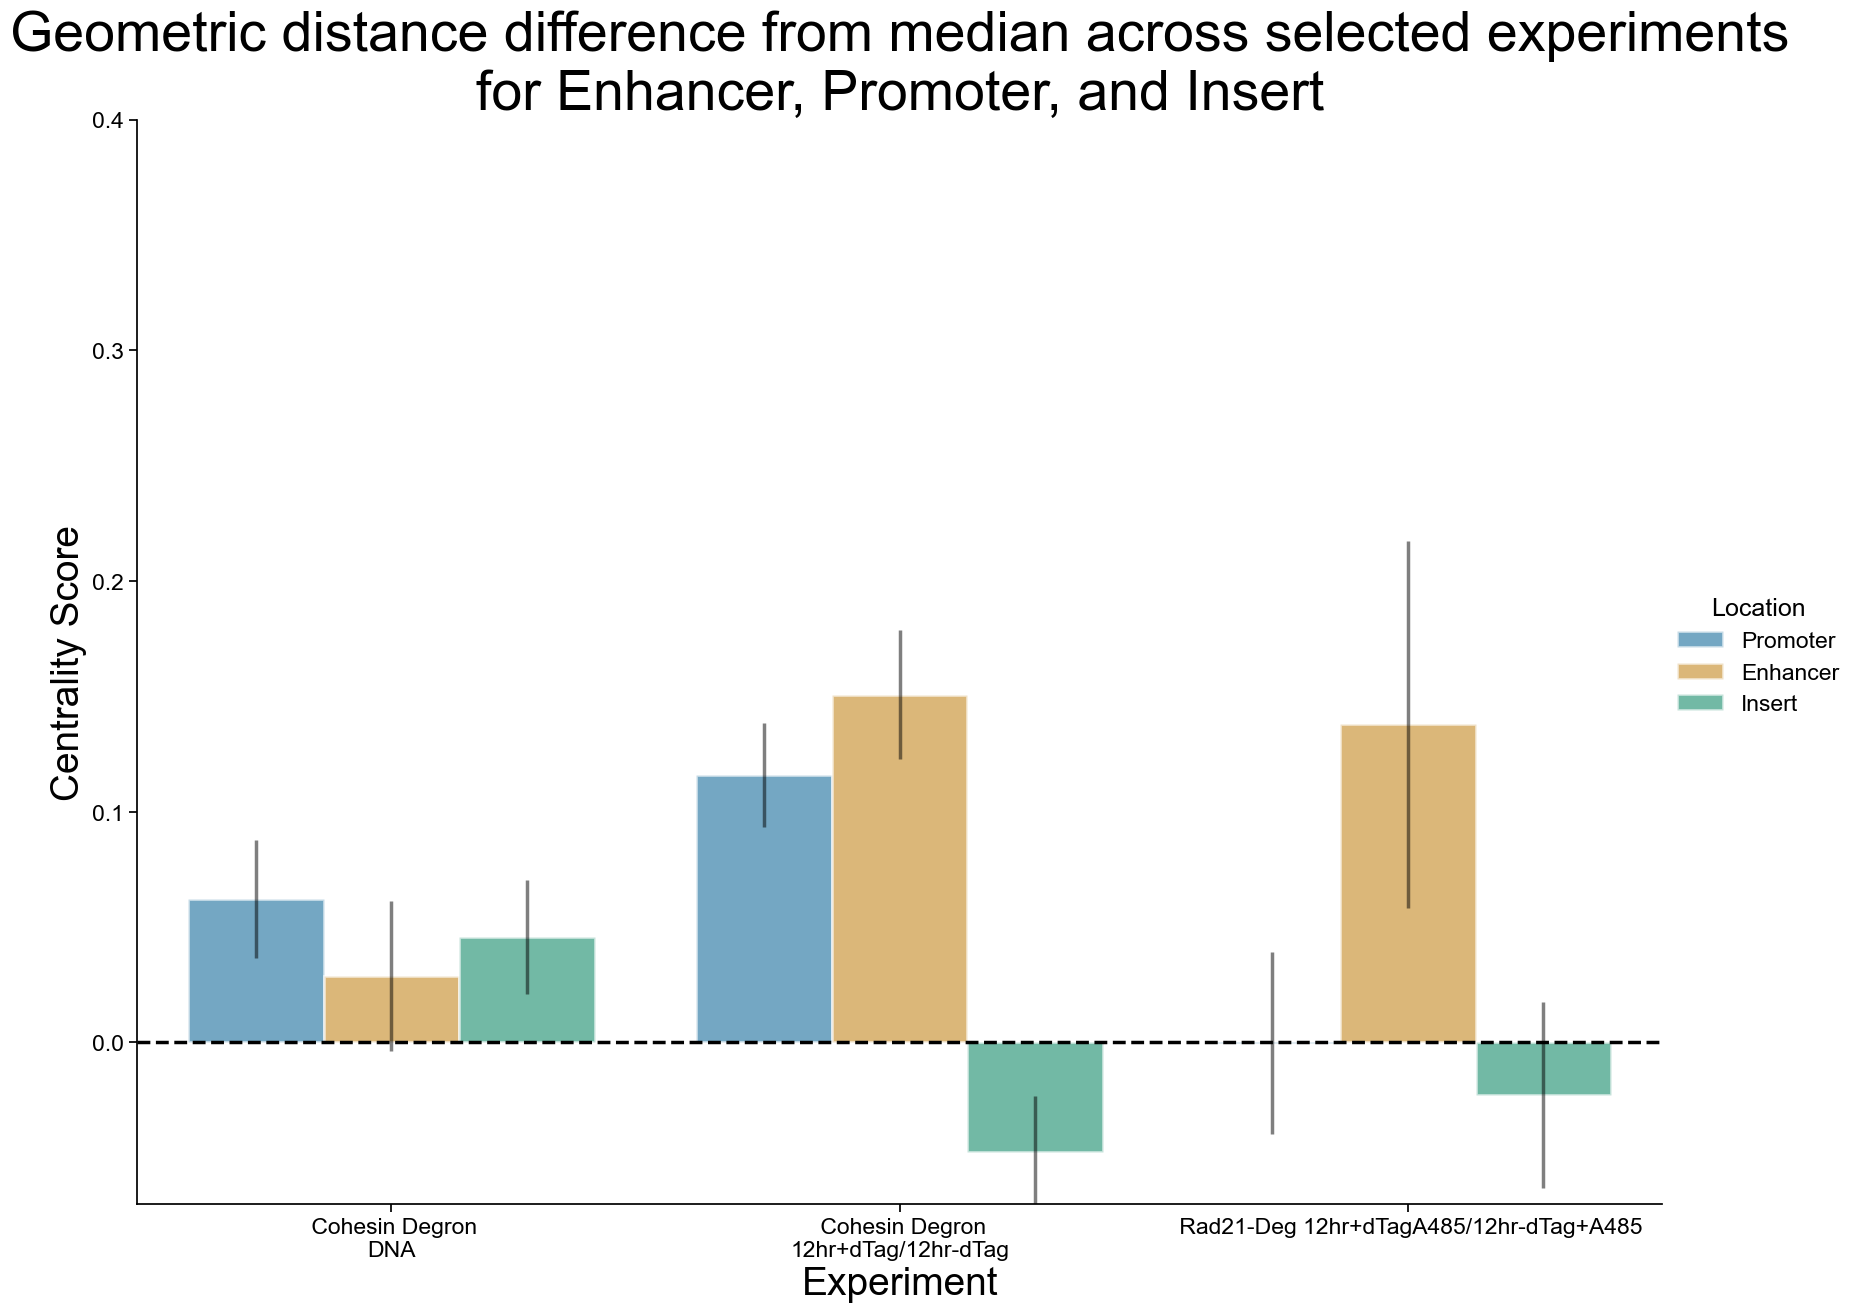

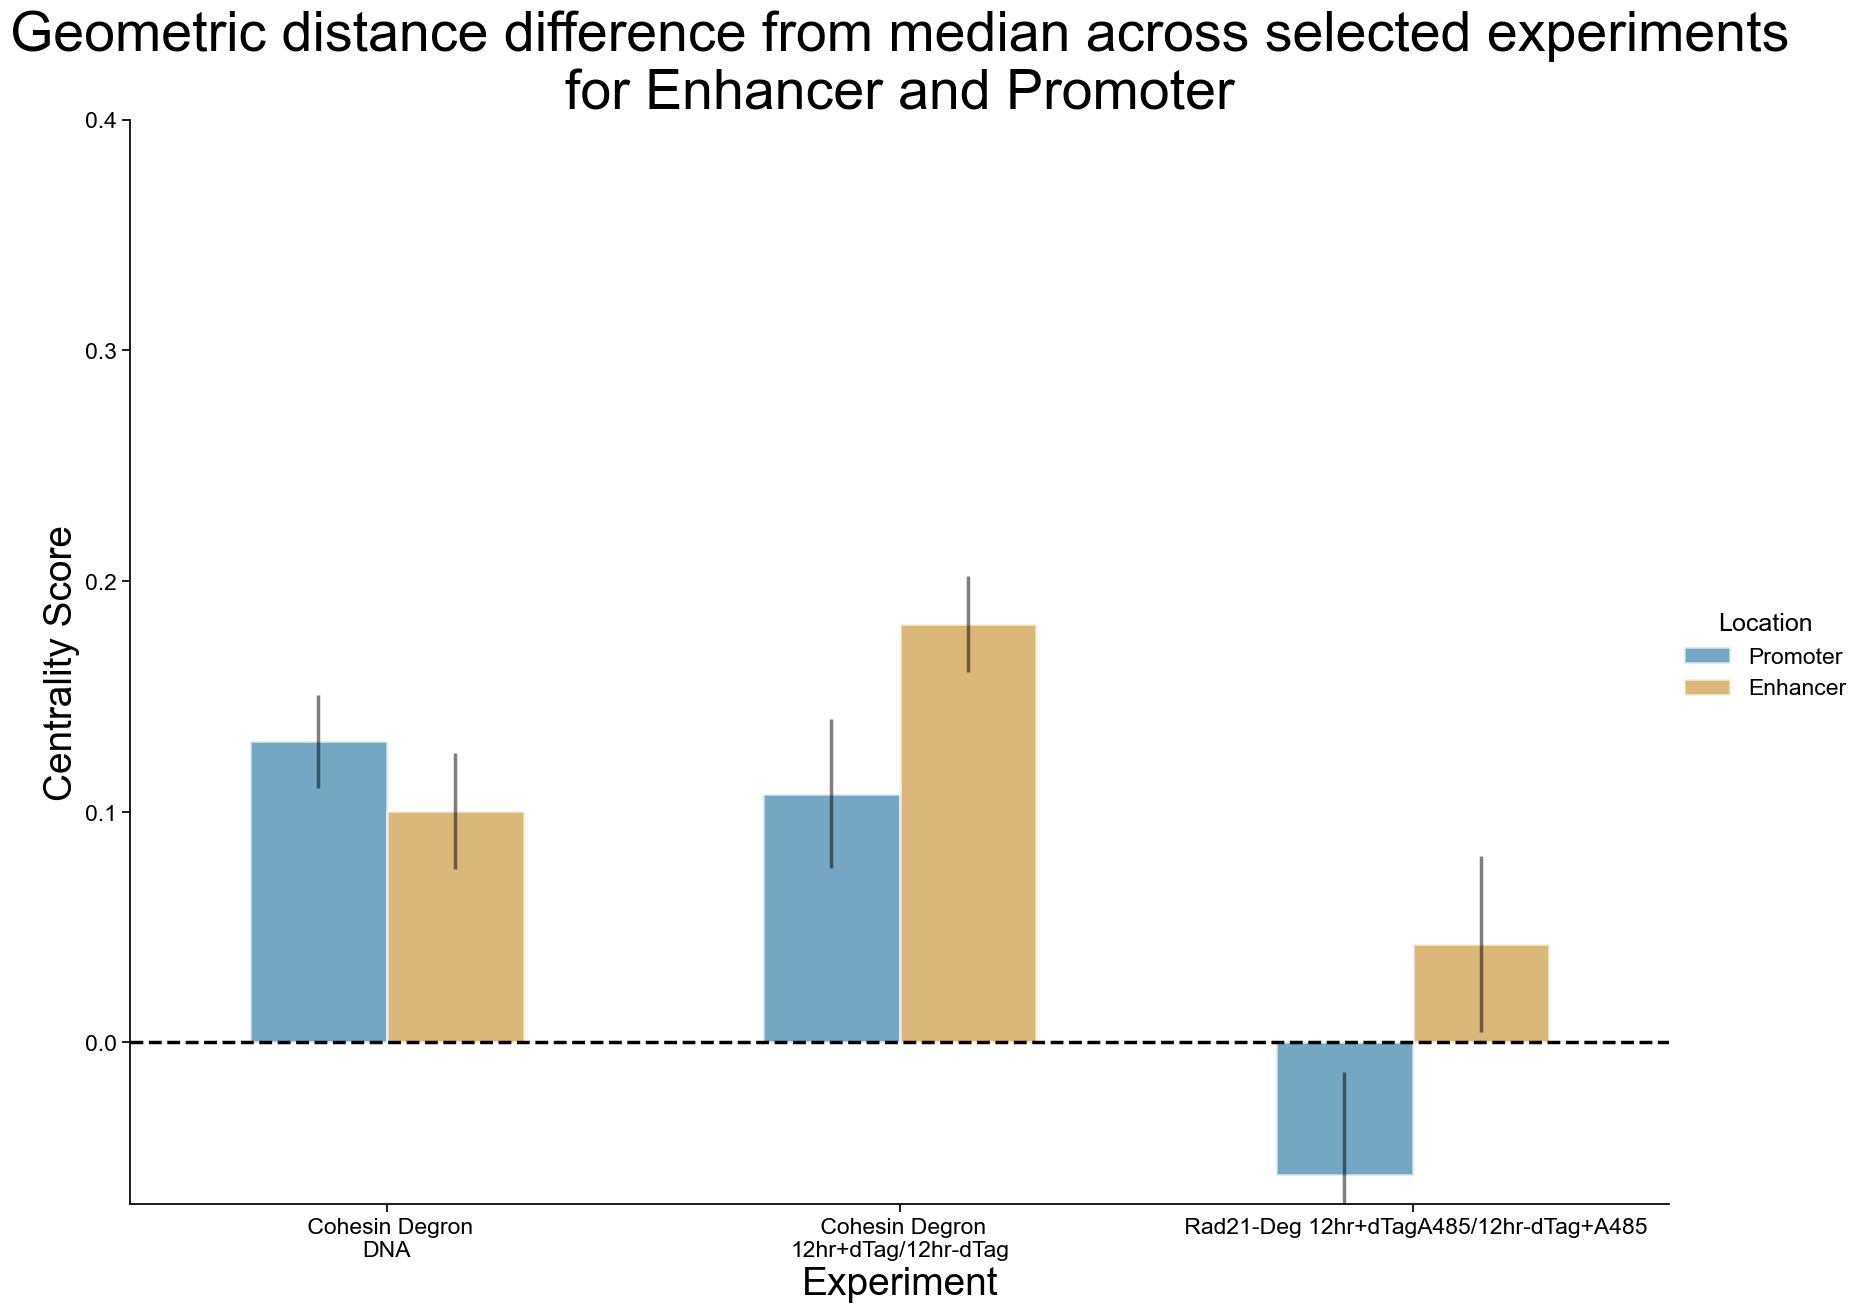

In [158]:
from matplotlib import pyplot
import seaborn
import matplotlib

matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=24)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.catplot(data=combined_df_cast_melt, x="Experiment", y="Centrality Score", hue="Location", 
            kind='bar', palette='colorblind', alpha=.6, height=12, aspect=11.7/8.27, edgecolor='white', linewidth=2, order=expts_to_plot)

# Get the x-positions of the bars
bar_x_positions = [bar.get_x() + bar.get_width() / 2 for bar in ax.ax.patches]
markers, caps, bars = plt.errorbar(x=bar_x_positions, y=combined_df_cast_melt['Centrality Score'], yerr=combined_df_cast_melt['Errors'], color='black', linestyle='')
[bar.set_alpha(0.5) for bar in bars ]
ax.set_xticklabels(expt_names)
plt.title('Geometric distance difference from median across selected experiments\nfor Enhancer, Promoter, and Insert', size=40)
plt.ylabel("Centrality Score", size=28)
plt.xlabel("Experiment", size=28)
plt.xlim(-0.5,len(expt_names)-0.5)
plt.hlines(0, -0.5, len(expt_names)-0.5, linestyles='dashed', colors='black')
plt.xticks
plt.ylim(-0.07,0.4)
plt.savefig(saveloc+os.sep+'centrality_scores_CAST_rad21_rec.pdf',bbox_inches='tight', dpi=300)
plt.savefig(saveloc+os.sep+'centrality_scores_CAST_rad21_rec.png',bbox_inches='tight', dpi=300)
plt.savefig(saveloc+os.sep+'centrality_scores_CAST_rad21_rec.svg',bbox_inches='tight', dpi=300)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.catplot(data=combined_df_129_melt, x="Experiment", y="Centrality Score", hue="Location", 
            kind='bar', palette='colorblind', alpha=.6, height=12, aspect=11.7/8.27, edgecolor='white', linewidth=2, order=expts_to_plot)

[ bar.set_x(bar.get_x()+ bar.get_width() / 3) if (idx<len(expts_to_plot)) else bar.get_x() for idx,bar in enumerate(ax.ax.patches)]
# Get the x-positions of the bars
bar_x_positions = [bar.get_x() + bar.get_width()/ 3 for bar in ax.ax.patches]

[ bar.set_width((bar.get_width()*2)/3) for bar in ax.ax.patches]
markers, caps, bars = plt.errorbar(x=bar_x_positions, y=combined_df_129_melt['Centrality Score'], yerr=combined_df_129_melt['Errors'], color='black', linestyle='')
[bar.set_alpha(0.5) for bar in bars]
ax.set_xticklabels(expt_names)
plt.title('Geometric distance difference from median across selected experiments\nfor Enhancer and Promoter', size=40)
plt.ylabel("Centrality Score", size=28)
plt.xlabel("Experiment", size=28)
plt.xlim(-0.5,len(expt_names)-0.5)
plt.hlines(0, -0.5, len(expt_names)-0.5, linestyles='dashed', colors='black')
plt.ylim(-0.07,0.4)

plt.savefig(saveloc+os.sep+'centrality_scores_129_rad21_rec.pdf',bbox_inches='tight', dpi=300)
plt.savefig(saveloc+os.sep+'centrality_scores_129_rad21_rec.png',bbox_inches='tight', dpi=300)
plt.savefig(saveloc+os.sep+'centrality_scores_129_rad21_rec.svg',bbox_inches='tight', dpi=300)

# save plot data.
np.save(saveloc+os.sep+r'centrality_scores_table_CAST_rad21_rec.npy', combined_df_cast_melt)
np.save(saveloc+os.sep+r'centrality_scores_table_129_rad21_rec.npy', combined_df_129_melt)

In [172]:
expts_to_plot

[17, 26, 16, 10]

In [173]:
threshold = 0.3
region_to_compare = 31

top_x_inds_expts_cast = []
top_x_inds_expts_129 = []

middle_x_inds_expts_cast = []
middle_x_inds_expts_129 = []

bottom_x_inds_expts_cast = []
bottom_x_inds_expts_129 = []

for expt in all_geom_dists_all_traces_cast[expts_to_plot]:
    
    centrality_prom = expt[:,region_to_compare]
    ordered_prom_dists = np.argsort(centrality_prom)
    nan_promoters = np.where(np.isnan(centrality_prom))[0]
    
    ordered_prom_dists = ordered_prom_dists[~np.array([ x in nan_promoters for x in ordered_prom_dists ])]
    
    total_traces = len(ordered_prom_dists)
    x = int(np.round(threshold*total_traces,0))
    top_x_inds = ordered_prom_dists[:x]
    bottom_x_inds = ordered_prom_dists[-x:]
    middle_x_inds = ordered_prom_dists[x+1:len(ordered_prom_dists)-x]
    print(x, middle_x_inds.shape, ordered_prom_dists.shape)
    middle_x_inds_expts_cast.append(middle_x_inds)
    top_x_inds_expts_cast.append(top_x_inds)
    bottom_x_inds_expts_cast.append(bottom_x_inds)
    
for expt in all_geom_dists_all_traces_129[expts_to_plot]:
    
    centrality_prom = expt[:,region_to_compare]
    ordered_prom_dists = np.argsort(centrality_prom)
    nan_promoters = np.where(np.isnan(centrality_prom))[0]
    
    ordered_prom_dists = ordered_prom_dists[~np.array([ x in nan_promoters for x in ordered_prom_dists ])]

    total_traces = len(ordered_prom_dists)
    x = int(np.round(threshold*total_traces,0))
    top_x_inds = ordered_prom_dists[:x]
    bottom_x_inds = ordered_prom_dists[-x:]
    middle_x_inds = ordered_prom_dists[x+1:-x]
    middle_x_inds_expts_129.append(middle_x_inds)
    top_x_inds_expts_129.append(top_x_inds)
    bottom_x_inds_expts_129.append(bottom_x_inds)
    

228 (303,) (760,)
968 (1288,) (3225,)
397 (527,) (1322,)
136 (180,) (453,)


In [174]:
%matplotlib inline
from scipy.spatial.distance import squareform,pdist,cdist
import matplotlib as mpl
plt.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family']='Arial'

In [175]:
def make_distance_matrix(medians, title, vmin, vmax, region, save=True, saveloc='', extension='', plot_region_line=False):   
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    plt.setp(ax.spines.values(), linewidth=1.5)
    ax.tick_params(width=1.5, length=4, labelsize=14)
    plt.title(title, size=24)
    plt.ylabel('Genomic Region Number', size=14)
    plt.xlabel('Genomic Region Number', size=14)
    plt.imshow(np.nanmedian(medians, axis=0), vmin=vmin, vmax=vmax, cmap='seismic_r')
    plt.colorbar()
    if save:
        plt.savefig(saveloc+os.sep+extension+'.png', bbox_inches='tight', dpi=300)
        plt.savefig(saveloc+os.sep+extension+'.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(saveloc+os.sep+extension+'.svg', bbox_inches='tight', dpi=300)
        
    if plot_region_line:
        fig = plt.figure(figsize=(6,5))
        ax = fig.add_subplot(111)
        plt.setp(ax.spines.values(), linewidth=1.5)
        ax.tick_params(width=1.5, length=4, labelsize=14)
        plt.title(title, size=24)
        plt.ylabel('Contact Distance', size=14)
        plt.xlabel('Genomic Region Number', size=14)
        stripe = np.nanmedian(medians, axis=0)[region,:]
        stripe[region-1:region+2] = np.nan
        plt.vlines([25, 31], 0, 500, colors='red', alpha=0.3, linewidth=4)
        plt.plot(range(42), stripe, color='black')
        if save:
            plt.savefig(saveloc+os.sep+extension+'_slice.png', bbox_inches='tight', dpi=300)
            plt.savefig(saveloc+os.sep+extension+'_slice.pdf', bbox_inches='tight', dpi=300)
            plt.savefig(saveloc+os.sep+extension+'_slice.svg', bbox_inches='tight', dpi=300)
        
    
    return None

def pad_df(items):

    maxsize = max([a.shape[0] for a in items])
    data_pad = [ np.pad(k, pad_width=(0,maxsize-k.shape[0]), mode='constant', constant_values=np.nan) for k in items]
    
    return data_pad
    
def make_ep_barplot(df, colnames, experiment_name, save=False, saveloc='', extension=''):
    
    fig, ax = plt.subplots(figsize=(11,8))
    sns.boxplot(data=df, palette='colorblind')
    ax.set_xticklabels(colnames, size=12)
    plt.xlabel("Experiment", size=20)
    plt.ylabel("Enhancer-Promoter Distance (nm)", size=20)
    plt.ylim(-20,1000)
    plt.title("Violin plot of radius of gyration for chromosomes\nin "+experiment_name, size=28)
    
    if save:
        plt.savefig(saveloc+os.sep+extension+'.png', bbox_inches='tight', dpi=300)
        plt.savefig(saveloc+os.sep+extension+'.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(saveloc+os.sep+extension+'.svg', bbox_inches='tight', dpi=300)
    
    return None

In [ ]:
subset = [expts[i] for i in expts_to_plot ]
import plotly.io as pio
pio.renderers.default = 'iframe'

import plotly.graph_objects as go
from scipy.interpolate import InterpolatedUnivariateSpline

ModuleNotFoundError: No module named 'plotly'

In [177]:
subset = [expts[i] for i in expts_to_plot ]

for idx, expt in enumerate(subset):
    
    experiment_name = expt.experiment_name
    
    traces_cast = np.load(expt.traces_cast)
    traces_129 = np.load(expt.traces_129)
    traces_129[:,25] = [np.nan, np.nan, np.nan]
    
    traces_cast_top = traces_cast[top_x_inds_expts_cast[idx]]
    traces_129_top = traces_129[top_x_inds_expts_129[idx]]
    
    traces_cast_middle = traces_cast[middle_x_inds_expts_cast[idx]]
    traces_129_middle = traces_129[middle_x_inds_expts_129[idx]]
    
    traces_cast_bottom = traces_cast[bottom_x_inds_expts_cast[idx]]
    traces_129_bottom = traces_129[bottom_x_inds_expts_129[idx]]
    break

xs,ys,zs = traces_cast[0][:,0], traces_cast[0][:,1], traces_cast[0][:,2]

# Create mask for valid data
valid_mask = ~np.isnan(xs) & ~np.isnan(ys) & ~np.isnan(zs)
xs_select = xs[[9,25,31]]
ys_select = ys[[9,25,31]]
zs_select = zs[[9,25,31]]
xs = xs[valid_mask]
ys = ys[valid_mask]
zs = zs[valid_mask]

# Parameters for the tube
radius = 7  # Radius of the tube
theta = np.linspace(0, 2 * np.pi, 30)  # Angle for creating the circle

# Create a meshgrid for the tube cross-section
theta_grid, t_valid_grid = np.meshgrid(theta, np.arange(len(xs_valid)))

# Tube coordinates
x_tube = np.zeros_like(theta_grid)
y_tube = np.zeros_like(theta_grid)
z_tube = np.zeros_like(theta_grid)

color_gradient = np.linspace(0, 1, len(xs_valid))
colors = np.zeros_like(theta_grid)
for i in range(len(xs_valid)):
    x_tube[i, :] = xs_valid[i] + radius * np.cos(theta_grid[i, :])
    y_tube[i, :] = ys_valid[i] + radius * np.sin(theta_grid[i, :])
    z_tube[i, :] = zs_valid[i]
    colors[i, :] = color_gradient[i]

# Create 3D mesh for the tube with color
tube_surface = go.Surface(
    x=x_tube, y=y_tube, z=z_tube,
    surfacecolor=colors,  # Apply color gradient
    colorscale='Rainbow',  # Use rainbow color scale
    showscale=True,  # Show color scale
    opacity=0.4,
    name='Tube Surface'
)

# Small dots at each point
scatter_points = go.Scatter3d(
    x=xs, y=ys, z=zs,
    mode='markers',
    marker=dict(size=3, color='red'),
    name='All Points'
)


# Small spheres at each point
scatter_points = go.Scatter3d(
    x=xs, y=ys, z=zs,
    mode='markers',
    marker=dict(size=8, color='brown', symbol='circle'),  # Spheres
    name='All Points'
)

# Larger spheres at selected points (example: every original point)
selected_points = go.Scatter3d(
    x=xs_select, y=ys_select, z=zs_select,
    mode='markers',
    marker=dict(size=14, color=['pink','blue','green'], symbol='circle'),  # Larger spheres
    name='Selected Points'
)

# Larger dots at selected points (example: every 10th point)
selected_indices = np.arange(0, len(xs), 1)
centeroid = go.Scatter3d(
    x=[np.nanmedian(xs)], y=[np.nanmedian(ys)], z=[np.nanmedian(zs)],
    mode='markers',
    marker=dict(size=12, color='black'),
    name='Selected Points'
)

# Combine all traces
fig = go.Figure(data=[tube_surface, scatter_points, selected_points, centeroid])

# Update layout for better visualization
fig.update_layout(scene=dict(
    xaxis=dict(showgrid=False, showticklabels=False, title=''),
    yaxis=dict(showgrid=False, showticklabels=False, title=''),
    zaxis=dict(showgrid=False, showticklabels=False, title=''),
))

fig.show()

NameError: name 'xs_valid' is not defined

In [179]:
subset = [expts[i] for i in expts_to_plot ]

for idx, expt in enumerate(subset):
    
    experiment_name = expt.experiment_name
    
    traces_cast = np.load(expt.traces_cast)
    traces_129 = np.load(expt.traces_129)
    traces_129[:,25] = [np.nan, np.nan, np.nan]
    
    traces_cast_top = traces_cast[top_x_inds_expts_cast[idx]]
    traces_129_top = traces_129[top_x_inds_expts_129[idx]]
    
    traces_cast_middle = traces_cast[middle_x_inds_expts_cast[idx]]
    traces_129_middle = traces_129[middle_x_inds_expts_129[idx]]
    
    traces_cast_bottom = traces_cast[bottom_x_inds_expts_cast[idx]]
    traces_129_bottom = traces_129[bottom_x_inds_expts_129[idx]]
    break

xs,ys,zs = traces_cast_top[40][:,0], traces_cast_top[40][:,1], traces_cast_top[40][:,2]

# Create mask for valid data
valid_mask = ~np.isnan(xs) & ~np.isnan(ys) & ~np.isnan(zs)
xs_select = xs[[9,25,31]]
ys_select = ys[[9,25,31]]
zs_select = zs[[9,25,31]]
xs = xs[valid_mask]
ys = ys[valid_mask]
zs = zs[valid_mask]

# Parameters for the tube
radius = 10  # Radius of the tube
theta = np.linspace(0, 2 * np.pi, 30)  # Angle for creating the circle

# Create a meshgrid for the tube cross-section
theta_grid, t_valid_grid = np.meshgrid(theta, np.arange(len(xs_valid)))

# Tube coordinates
x_tube = np.zeros_like(theta_grid)
y_tube = np.zeros_like(theta_grid)
z_tube = np.zeros_like(theta_grid)

color_gradient = np.linspace(0, 1, len(xs))
colors = np.zeros_like(theta_grid)
for i in range(len(xs)):
    colors[i, :] = color_gradient[i]

# Smooth line connecting the points
line = go.Scatter3d(
    x=xs, y=ys, z=zs,
    mode='lines',
    line=dict(width=2, color=colors, colorscale='Rainbow')
)

# Small dots at each point
scatter_points = go.Scatter3d(
    x=xs, y=ys, z=zs,
    mode='markers',
    marker=dict(size=3, color='red'),
    name='All Points'
)


# Small spheres at each point
scatter_points = go.Scatter3d(
    x=xs, y=ys, z=zs,
    mode='markers',
    marker=dict(size=6, color='brown', symbol='circle'),  # Spheres
    name='All Points'
)

# Larger spheres at selected points (example: every original point)
selected_points = go.Scatter3d(
    x=xs_select, y=ys_select, z=zs_select,
    mode='markers',
    marker=dict(size=12, color=['#0173b2', '#de8f05', '#029e73'], symbol='circle'),  # Larger spheres
    name='Selected Points'
)

# Larger dots at selected points (example: every 10th point)
selected_indices = np.arange(0, len(xs), 1)
centeroid = go.Scatter3d(
    x=[np.nanmedian(xs)], y=[np.nanmedian(ys)], z=[np.nanmedian(zs)],
    mode='markers',
    marker=dict(size=14, color='black'),
    name='Selected Points'
)

# Combine all traces
fig = go.Figure(data=[line, scatter_points, selected_points, centeroid])

# Update layout for better visualization
fig.update_layout(paper_bgcolor="white", plot_bgcolor='white', scene=dict(
    xaxis=dict(showgrid=False, showticklabels=False, title=''),
    yaxis=dict(showgrid=False, showticklabels=False, title=''),
    zaxis=dict(showgrid=False, showticklabels=False, title=''),
))

fig.show()

NameError: name 'xs_valid' is not defined

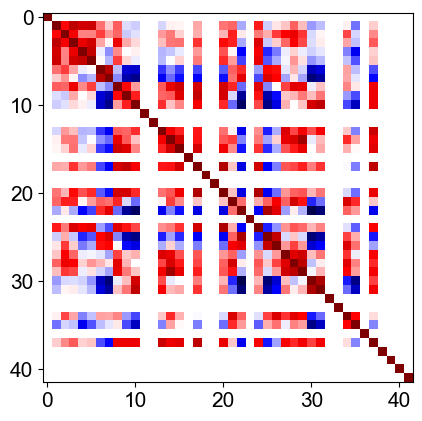

In [180]:
heatmap_cast = np.array(squareform(pdist(traces_cast_bottom[40])))
plt.imshow(heatmap_cast, cmap='seismic_r')

In [181]:
subset = [expts[i] for i in expts_to_plot ]
vmin = 0
vmax = 500

for idx, expt in enumerate(subset):
    
    experiment_name = expt.experiment_name
    
    traces_cast = np.load(expt.traces_cast)
    traces_129 = np.load(expt.traces_129)
    traces_129[:,25] = [np.nan, np.nan, np.nan]
    
    traces_cast_top = traces_cast[top_x_inds_expts_cast[idx]]
    traces_129_top = traces_129[top_x_inds_expts_129[idx]]
    
    traces_cast_middle = traces_cast[middle_x_inds_expts_cast[idx]]
    traces_129_middle = traces_129[middle_x_inds_expts_129[idx]]
    
    traces_cast_bottom = traces_cast[bottom_x_inds_expts_cast[idx]]
    traces_129_bottom = traces_129[bottom_x_inds_expts_129[idx]]
    
    # get pairwise distances from traces
    pairwise_cast_top = np.array(list(map(squareform,list(map(pdist,traces_cast_top)))))
    pairwise_129_top = np.array(list(map(squareform,list(map(pdist,traces_129_top)))))
    
    pairwise_cast_bottom = np.array(list(map(squareform,list(map(pdist,traces_cast_bottom)))))
    pairwise_129_bottom = np.array(list(map(squareform,list(map(pdist,traces_129_bottom)))))
    
    pairwise_cast_middle = np.array(list(map(squareform,list(map(pdist,traces_cast_middle)))))
    pairwise_129_middle = np.array(list(map(squareform,list(map(pdist,traces_129_middle)))))
    
    # get EP dists for each condition
    ep_dists_cast_all = np.array(list(map(squareform,list(map(pdist,traces_cast)))))[:,10,31]
    #ep_dists_129_all = np.array(list(map(squareform,list(map(pdist,traces_129)))))[:,10,31]
    ep_dists_cast_top = pairwise_cast_top[:,10,31]
    ep_dists_cast_bottom = pairwise_cast_bottom[:,10,31]
    ep_dists_cast_middle = pairwise_cast_middle[:,10,31]
    #ep_dists_129_top = pairwise_129_top[:,10,31]
    #ep_dists_129_bottom = pairwise_129_bottom[:,10,31]
    #ep_dists_129_middle = pairwise_129_middle[:,10,31]
    
    index=['CAST Top', 'CAST Middle', 'CAST Bottom', 'CAST all']#, '129 Top', '129_middle', '129 Bottom', '129_all']
    ep_list = pad_df([ep_dists_cast_top, ep_dists_cast_middle, ep_dists_cast_bottom, ep_dists_cast_all])#, ep_dists_129_top, ep_dists_129_middle, ep_dists_129_bottom, ep_dists_cast_all])
    ep_df = pd.DataFrame(ep_list, index=index).T
    make_ep_barplot(ep_df, index, experiment_name, save=True, saveloc=saveloc, extension='E-P_dists_centrality_groups_region_'+str(region_to_compare)+'_'+experiment_name.replace(' ', '_'))
    
    title = 'Median distance for\n CAST top '+str(len(top_x_inds_expts_cast[idx]))+' chromosomes\n'+experiment_name
    make_distance_matrix(pairwise_cast_top, title, vmin, vmax, region_to_compare, save=True, saveloc=saveloc, 
                         extension='CAST_top_median_region_'+str(region_to_compare)+'_'+experiment_name.replace(' ', '_'), plot_region_line=False)
    
    title = 'Median distance for\n CAST bottom '+str(len(bottom_x_inds_expts_cast[idx]))+' chromosomes\n'+experiment_name
    make_distance_matrix(pairwise_cast_bottom, title, vmin, vmax, region_to_compare, save=True, saveloc=saveloc, 
                         extension='CAST_bottom_median_region_'+str(region_to_compare)+'_'+experiment_name.replace(' ', '_'), plot_region_line=False)
    
    title = 'Median distance for\n 129 top '+str(len(top_x_inds_expts_129[idx]))+' chromosomes\n'+experiment_name
    make_distance_matrix(pairwise_129_top, title, vmin, vmax, region_to_compare, save=True, saveloc=saveloc, 
                         extension='129_top_median_region_'+str(region_to_compare)+'_'+experiment_name.replace(' ', '_'), plot_region_line=False)
    
    title = 'Median distance for\n 129 bottom '+str(len(bottom_x_inds_expts_129[idx]))+' chromosomes\n'+experiment_name
    make_distance_matrix(pairwise_129_bottom, title, vmin, vmax, region_to_compare, save=True, saveloc=saveloc, 
                         extension='129_bottom_median_region_'+str(region_to_compare)+'_'+experiment_name.replace(' ', '_'), plot_region_line=False)

C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002193A599B88> (for post_execute):


KeyboardInterrupt: 

<h4> Defining Co-centrality as a binary presence of both enhancer and promoter below a threshold </h4>

In [252]:
threshold = 200
cocentrality_cast = []
cocentrality_129 = []

for expt in all_geom_dists_all_traces_cast[expts_to_plot]:
    central = (np.array(expt)<threshold)*1
    cocentrality = central[:,9]*central[:,31]
    fraction_cocentral = sum(cocentrality)/len(cocentrality)
    cocentrality_cast.append(fraction_cocentral)

for expt in all_geom_dists_all_traces_129[expts_to_plot]:
    central = (np.array(expt)<threshold)*1
    cocentrality = central[:,9]*central[:,31]
    fraction_cocentral = sum(cocentrality)/len(cocentrality)
    cocentrality_129.append(fraction_cocentral)
    
cocentrality_binary_cast = np.array(cocentrality_cast)
cocentrality_binary_129 = np.array(cocentrality_129)

In [253]:
cocentrality_cast = []
cocentrality_129 = []

for expt in all_geom_dists_all_traces_cast[expts_to_plot]:
    cocentrality = [ np.sqrt(x[9]**2+x[31]**2) for x in expt ]
    cocentrality_cast.append(np.nanmedian(cocentrality))

for expt in all_geom_dists_all_traces_129[expts_to_plot]:
    cocentrality = [ np.sqrt(x[9]**2+x[31]**2) for x in expt ]
    cocentrality_129.append(np.nanmedian(cocentrality))
    
cocentrality_cast = np.array(cocentrality_cast)
cocentrality_129 = np.array(cocentrality_129)

In [254]:
cocentrality_cast, cocentrality_129

(array([235.57552056, 282.23462488, 355.34911256, 311.02591625]),
 array([220.00465871, 299.44632487, 340.63041294, 308.82936754]))

In [255]:
p = [8,9,10]     #Segments that include the promoter (counting from 0)
e = [30,31,32]   #Segments that include the super-enhancer (counting from 0)
def get_ep_dists_nans(zxys):
    dists_ep = []
    for p_i in p:
        for e_i in e:
            p_ = np.nanmedian(np.array(zxys)[:,[p_i]],axis=1)#if feature spans multiple regions get the mean position
            e_ = np.nanmedian(np.array(zxys)[:,[e_i]],axis=1)
            dists_ep.append(np.linalg.norm(p_-e_,axis=-1))

    dists_ep = np.nanmedian(dists_ep,axis=0)
    return dists_ep

In [256]:
median_ep_dists_cast = []
median_ep_dists_129 = [] 

frac_ep_dists_cast = []
frac_ep_dists_129 = []

subset = [expts[i] for i in expts_to_plot ]

for idx, expt in enumerate(subset):
    
    experiment_name = expt.experiment_name
    
    traces_cast = np.load(expt.traces_cast)
    traces_129 = np.load(expt.traces_129)
    traces_129[:,25] = [np.nan, np.nan, np.nan]
    
    # get EP dists for each condition
    ep_dists_cast_all = get_ep_dists_nans(traces_cast)
    ep_dists_129_all = get_ep_dists_nans(traces_129)
    
    #calculate fraction of ep distances below a threshold
    binary_ep_dist_cast = (ep_dists_cast_all<threshold)*1
    binary_ep_dist_129 = (ep_dists_129_all<threshold)*1
    frac_ep_cast = sum(binary_ep_dist_cast)/len(binary_ep_dist_cast)
    frac_ep_129 = sum(binary_ep_dist_129)/len(binary_ep_dist_129)
    
    frac_ep_dists_cast.append(frac_ep_cast)
    frac_ep_dists_129.append(frac_ep_129)
    
    median_ep_dists_cast.append(np.nanmedian(ep_dists_cast_all))
    median_ep_dists_129.append(np.nanmedian(ep_dists_129_all))
    

C:\Users\Administrator\Anaconda3\envs\cellpose\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [257]:
for expt in subset:
    print(expt.experiment_name)

D0097 CTCF Degron -dTag
D0099 C3 CTCF Degron -dTag diff
D0106 CTCF Degron +dTag 12hr
D0098 C3 CTCF Degron +dTag diff


In [258]:
promoter_centrality = pd.concat([ df_cast['Promoter'], df_129['Promoter']]).to_list()
enhancer_centrality = pd.concat([ df_cast['Enhancer'], df_129['Enhancer']]).to_list()
median_eps = np.concatenate([median_ep_dists_cast, median_ep_dists_129])
#cocentrality = np.concatenate([cocentrality_cast, cocentrality_129])
#cocentrality_binary = np.concatenate([cocentrality_binary_cast, cocentrality_binary_129])

#expression computed by bharath and pasted here in order
#expression = np.array([1443.488,2001.096,1201.704,3013.367,2489.503,3582.518,5532.052,5582.822,4790.250,4446.057])
expression = np.array([2001.096,1201.704,3013.367,2489.503,5532.052,5582.822,4790.250,4446.057])

# averaging rep1/rep2 for acetylation.
#e_ac_CAST = ( np.array([ 3373.59, 3528.03, 1953.41, 1299]) + np.array([ 1956.86, 3611.25, 2164.35, 1669.27 ]) ) /2
#p_ac_CAST = ( np.array([ 855.69, 575.22, 839.97, 1026.91]) + np.array([ 624.88, 626.12, 1085.42, 1345.38 ]) ) /2
#e_ac_129 = ( np.array([ 1002.44, 980.43, 943.51, 716.21]) + np.array([ 731.16, 868.54, 1057.55, 901.33 ]) ) /2
#p_ac_129 = ( np.array([ 2044.2, 2218.88, 1741.12, 1635.8]) + np.array([ 1543.57, 1800.48, 2471.95, 2566.28]) ) /2

#e_ac = np.concatenate([e_ac_CAST, e_ac_129])
#p_ac = np.concatenate([p_ac_CAST, p_ac_129])

order = np.argsort(expression)[::-1]
frac_ep_dists = np.concatenate([np.array(frac_ep_dists_cast), np.array(frac_ep_dists_129)])

In [259]:
names = ['CTCF -dTag\n2iL CAST', 'CTCF -dTag\nDiff CAST', 'CTCF +dTag\n 2iL CAST', 'CTCF +dTag\n Diff CAST', 
         'CTCF -dTag\n2iL 129', 'CTCF -dTag\nDiff 129', 'CTCF +dTag\n 2iL 129', 'CTCF +dTag\n Diff 129']
names = np.array(names)[order]

In [260]:
promoter_centrality = np.array(promoter_centrality)[order]
enhancer_centrality = np.array(enhancer_centrality)[order]
median_eps = median_eps[order]
expression = expression[order]
frac_ep_dists = frac_ep_dists[order]

In [261]:
import pandas as pd
from scipy.stats import pearsonr

# Sample data
data = {
    'RNA': expression,
    'Enh Centrality': enhancer_centrality,
    'Prom Centrality': promoter_centrality,
    'E-P Contact': frac_ep_dists,
}

# Creating a DataFrame
df = pd.DataFrame(data)

In [262]:
df

,RNA,Enh Centrality,Prom Centrality,E-P Contact
0,5582.822,0.176044,0.076440,0.151825
1,5532.052,0.187855,0.104643,0.374468
2,4790.250,0.180049,0.108192,0.136039
3,4446.057,0.178167,0.055989,0.149378
4,3013.367,0.149747,0.090342,0.111536
5,2489.503,0.146191,0.064942,0.153527
6,2001.096,0.016157,0.159935,0.228369
7,1201.704,0.058877,0.100785,0.148905


                      RNA  Enh Centrality  Prom Centrality  E-P Contact
RNA                   NaN        0.010291         0.456736     0.454856
Enh Centrality   0.010291             NaN         0.060803     0.945100
Prom Centrality  0.456736        0.060803              NaN     0.366769
E-P Contact      0.454856        0.945100         0.366769          NaN


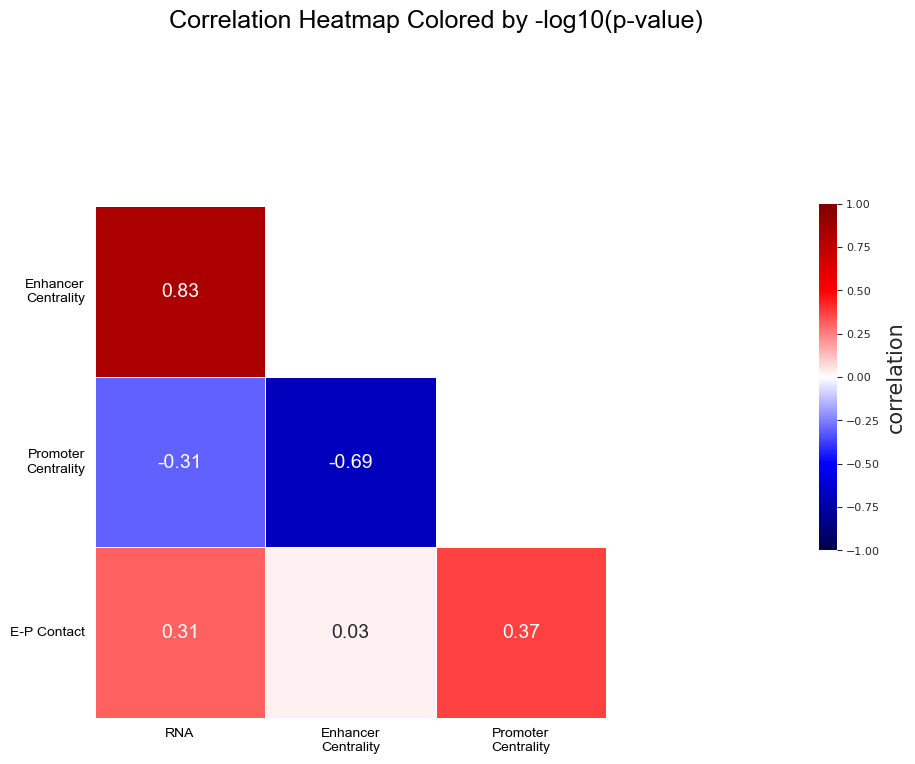

In [270]:
def corr_pval_matrix(df):
    corr_matrix = df.corr()
    pval_matrix = pd.DataFrame(np.zeros_like(corr_matrix), columns=df.columns, index=df.columns)
    
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                corr, pval = pearsonr(df[col1], df[col2])
                pval_matrix.loc[col1, col2] = pval
            else:
                pval_matrix.loc[col1, col2] = np.nan  # p-value for correlation with self is not defined

    return corr_matrix, pval_matrix

# Calculate correlation matrix and p-value matrix
corr_matrix, pval_matrix = corr_pval_matrix(df)

# Apply negative log10 transformation to p-values
log_pval_matrix = -np.log10(pval_matrix)
print(pval_matrix)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(log_pval_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
with sns.axes_style("white"):
    ax = sns.heatmap(
            corr_matrix, 
            mask=mask, 
            cmap='seismic', 
            vmin=-1, 
            vmax=1,
            center=0, 
            annot=corr_matrix, 
            fmt=".2f",
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5, "label": "correlation"},
            annot_kws={"size": 14, "fontfamily": "Arial"}
        )
    ax.set_xticklabels(["RNA", "Enhancer\nCentrality", "Promoter\nCentrality",""], size=10)
    ax.set_yticklabels(["", "Enhancer\nCentrality", "Promoter\nCentrality","E-P Contact"], size=10, rotation=0)
    ax.tick_params(bottom=False, left=False)

plt.title('Correlation Heatmap Colored by -log10(p-value)')

plt.savefig(saveloc+os.sep+'correlation_matrix_RNA_diff.pdf',bbox_inches='tight', dpi=300)
plt.savefig(saveloc+os.sep+'correlation_matrix_RNA_diff.png',bbox_inches='tight', dpi=300)

plt.show()



In [ ]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [74]:
i = 0
box_width=0.15

   Centrality Score Enhancer    region
0         -0.793973     CAST  enhancer
1          0.518066     CAST  enhancer
2         -0.378718     CAST  enhancer
4         -0.110843     CAST  enhancer
6         -0.236438     CAST  enhancer
Enhancer
129     0.191278
CAST    0.023146
Name: Centrality Score, dtype: float64


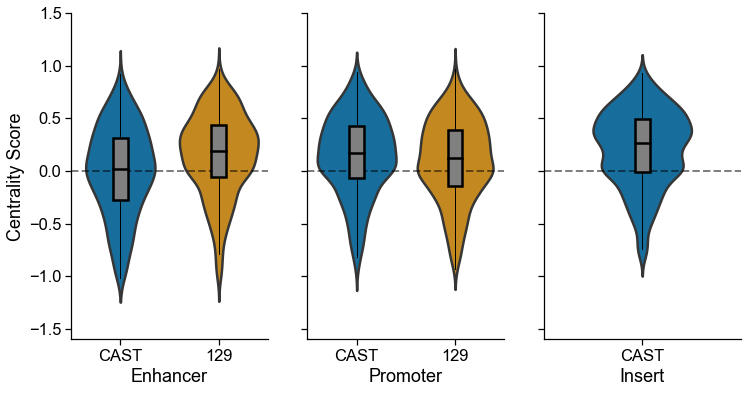

In [75]:
ctcf_ctrl_129_e = centrality_scores_e_129[i]
ctcf_ctrl_cast_e = centrality_scores_e_cast[i]

df_ctcf_ctrl_129 = pd.DataFrame([ctcf_ctrl_129_e, ['129']*len(ctcf_ctrl_129_e)], index=['Centrality Score', 'Enhancer']).T
df_ctcf_ctrl_cast = pd.DataFrame([ctcf_ctrl_cast_e, ['CAST']*len(ctcf_ctrl_cast_e)], index=['Centrality Score', 'Enhancer']).T
df_combined_e = pd.concat([df_ctcf_ctrl_cast, df_ctcf_ctrl_129])
df_combined_e[["Centrality Score"]] = df_combined_e[["Centrality Score"]].astype(float)
df_combined_e[["Enhancer"]] = df_combined_e[["Enhancer"]].astype(str)
df_combined_e = df_combined_e[~np.isnan(df_combined_e['Centrality Score'].to_numpy())]
df_combined_e['region'] = 'enhancer'

df_combined = remove_outliers(df_combined_e, 'Centrality Score')


print(df_combined.head())
median = df_combined.groupby('Enhancer')['Centrality Score'].median()
print(median)

fig, axs = plt.subplots(1, 3, figsize=(12,6), sharey=True)

g1 = sns.violinplot(data=df_combined, x='Enhancer', y='Centrality Score', inner=None, ax=axs[0], palette='colorblind', showfliers=False)

sns.boxplot(
    x='Enhancer', y='Centrality Score', data=df_combined, 
    width=box_width, showcaps=False, 
    boxprops={'facecolor': 'gray', 'edgecolor': 'black', 'zorder':2}, 
    whiskerprops={'linewidth': 1, 'color': 'black'},
    flierprops={'marker': 'o', 'markersize': 0},  # Hide outliers
    medianprops={'color': 'black'}, 
    showfliers=False,
    dodge=True,
    ax=axs[0]  # Use the same axis
)



ctcf_ctrl_129_p = centrality_scores_p_129[i]
ctcf_ctrl_cast_p = centrality_scores_p_cast[i]

df_ctcf_ctrl_129 = pd.DataFrame([ctcf_ctrl_129_p, ['129']*len(ctcf_ctrl_129_p)], index=['Centrality Score', 'Promoter']).T
df_ctcf_ctrl_cast = pd.DataFrame([ctcf_ctrl_cast_p, ['CAST']*len(ctcf_ctrl_cast_p)], index=['Centrality Score', 'Promoter']).T
df_combined_p = pd.concat([df_ctcf_ctrl_cast, df_ctcf_ctrl_129])
df_combined_p[["Centrality Score"]] = df_combined_p[["Centrality Score"]].astype(float)
df_combined_p[["Promoter"]] = df_combined_p[["Promoter"]].astype(str)
df_combined_p = df_combined_p[~np.isnan(df_combined_p['Centrality Score'].to_numpy())]
df_combined_p['region'] = 'promoter'

axs[0].axhline(0.0, color='black', alpha=0.5, linestyle='--', linewidth=2)

df_combined=remove_outliers(df_combined_p, 'Centrality Score')

g2 = sns.violinplot(data=df_combined, x='Promoter', y='Centrality Score', inner=None, ax=axs[1], palette='colorblind', showfliers=False)

sns.boxplot(
    x='Promoter', y='Centrality Score', data=df_combined, 
    width=box_width, showcaps=False, 
    boxprops={'facecolor': 'gray', 'edgecolor': 'black', 'zorder':2}, 
    whiskerprops={'linewidth': 1, 'color': 'black'},
    flierprops={'marker': 'o', 'markersize': 0},  # Hide outliers
    medianprops={'color': 'black'}, 
    showfliers=False,
    dodge=True,
    ax=axs[1]  # Use the same axis
)

axs[1].axhline(0.0, color='black', alpha=0.5, linestyle='--', linewidth=2)

ctcf_ctrl_cast_i = centrality_scores_i_cast[i]

df_ctcf_ctrl_cast = pd.DataFrame([ctcf_ctrl_cast_i, ['CAST']*len(ctcf_ctrl_cast_i)], index=['Centrality Score', 'Insert']).T
df_combined_i = df_ctcf_ctrl_cast
df_combined_i[["Centrality Score"]] = df_combined_i[["Centrality Score"]].astype(float)
df_combined_i[["Insert"]] = df_combined_i[["Insert"]].astype(str)
df_combined_i = df_combined_i[~np.isnan(df_combined_i['Centrality Score'].to_numpy())]
df_combined_i['region'] = 'Insert'

df_combined = remove_outliers(df_combined_i, 'Centrality Score')

g3 = sns.violinplot(data=df_combined, x='Insert', y='Centrality Score', inner=None, ax=axs[2], palette='colorblind', showfliers=False, width=0.5)

sns.boxplot(
    x='Insert', y='Centrality Score', data=df_combined, 
    width=box_width*0.5, showcaps=False, 
    boxprops={'facecolor': 'gray', 'edgecolor': 'black', 'zorder':2}, 
    whiskerprops={'linewidth': 1, 'color': 'black'},
    flierprops={'marker': 'o', 'markersize': 0},  # Hide outliers
    medianprops={'color': 'black'}, 
    showfliers=False,
    dodge=True,
    ax=axs[2]  # Use the same axis
)
axs[1].set_ylabel("")
axs[2].set_ylabel("")
plt.ylim(-1.6, 1.5)
axs[2].axhline(0.0, color='black', alpha=0.5, linestyle='--', linewidth=2)

sns.despine()
plt.savefig(saveloc+os.sep+'4CBS_centrality_violinplots.pdf',bbox_inches='tight', dpi=300)
plt.savefig(saveloc+os.sep+'4CBS_centrality_violinplots.png',bbox_inches='tight', dpi=300)

In [90]:
from scipy.stats import wilcoxon

In [93]:
i = 0
print(wilcoxon(centrality_scores_e_129[i], centrality_scores_e_cast[i]))
print(wilcoxon(centrality_scores_p_129[i], centrality_scores_p_cast[i]))

WilcoxonResult(statistic=42407.0, pvalue=1.6402430249771632e-194)
WilcoxonResult(statistic=124431.0, pvalue=2.2886157663156903e-131)
